## 0. Was that you, RNN? 🤔

![I Doubt!](https://media.giphy.com/media/puOukoEvH4uAw/giphy.gif)

---

### Was considering the mRNA sequence as a Sequence rather than a Graph Structre was a Mistake?

**From:**
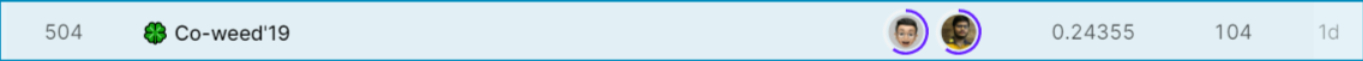


**To:**
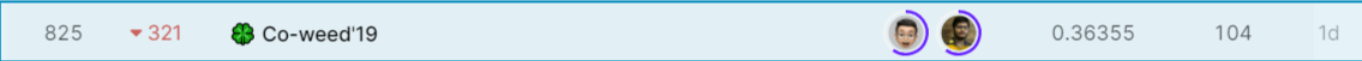

There could be a lot of other things that didn't go well with the private LB like, some features: [see this by @its7171](https://www.kaggle.com/its7171/dangerous-features).

---

Anyway, I learned a lot of new things and I will comeback even more stronger! ✌🏻

### Mistakes:

* Didn’t explore more about Test-set predictions & Train-set predictions after training.
* Distance Based Features?? Overfitted for small sequence (Train & Public)??
* Didn’t change BPPs Features for Augmented data, used the same features as before.

### INFERENCE after the Fall

* Maybe, RNNs o/p has higher target values than other models like GCN and Transformers.  ?? (https://www.kaggle.com/c/stanford-covid-vaccine/discussion/189182#1039989)
* TTA by predicting probable different structures and average the predictions.
* Use of BPPs matrix to get some kind of Embeddings. (https://www.kaggle.com/c/stanford-covid-vaccine/discussion/189236)
* Use of external libraries to generate bpps matrix & structures
* Self Supervised training - (Randomly dropping and predicting dropped nucleotides)
* More weight to scored columns is loss function
* Sample weights using errors or SNR.
* GCN with Attention using BPPs and other Features


### Some of the Top Solutions
* [13th place](https://www.kaggle.com/c/stanford-covid-vaccine/discussion/189585)
* [11th place](https://www.kaggle.com/c/stanford-covid-vaccine/discussion/189571)
* [23rd place](https://www.kaggle.com/c/stanford-covid-vaccine/discussion/189594)
* [BERT Solution](https://www.kaggle.com/c/stanford-covid-vaccine/discussion/189580)
* [7th place](https://www.kaggle.com/c/stanford-covid-vaccine/discussion/189564)
* [3rd place](https://www.kaggle.com/c/stanford-covid-vaccine/discussion/189574)
* [1st place](https://www.kaggle.com/c/stanford-covid-vaccine/discussion/189620)


### Things to look into
* GCNs - (Edge Conv)
* Transformers
* Lookahead & RAdam Optimizers

## 1. Import Necessary Libraries

In [ ]:
import warnings
warnings.filterwarnings('ignore')

import os, gc
import numpy as np
import pandas as pd
from collections import defaultdict,Counter
import random

import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('fivethirtyeight')

import tensorflow as tf
import tensorflow_addons as tfa
import keras.backend as K
print("Tensorflow version: ",tf.__version__)

# from transformers import *

from sklearn.model_selection import StratifiedKFold, KFold, GroupKFold
from sklearn.metrics import mean_squared_error

from tqdm import tqdm 
import itertools

SEED = 2020

def seed_everything(SEED):
    np.random.seed(SEED)
    tf.random.set_seed(SEED)
    os.environ['PYTHONHASHSEED'] = str(SEED)

seed_everything(SEED)

In [ ]:
AUGMENTED = True
OHE = False

## 2. Load Data

In [ ]:
PATH = '/kaggle/input/stanford-covid-vaccine'
os.listdir(PATH)

In [ ]:
train = pd.read_json(os.path.join(PATH,'train.json'),lines=True).drop('index',axis=1)
test = pd.read_json(os.path.join(PATH,'test.json'),lines=True).drop('index',axis=1)
sub = pd.read_csv(os.path.join(PATH,'sample_submission.csv'))

In [ ]:
if AUGMENTED:
    train = pd.read_json('../input/openvaccine/train.json').drop('index',axis=1)
    test = pd.read_json('../input/openvaccine/test.json').drop('index',axis=1)
    test = test[test.cnt==1]

In [ ]:
def get_bppm(id_):
    return np.load(os.path.join(PATH,f"bpps/{id_}.npy"))

In [ ]:
train.head().T

## 3. Preprocessing

In [ ]:
target_cols = ['reactivity', 'deg_Mg_pH10', 'deg_pH10', 'deg_Mg_50C', 'deg_50C']
feature_cols = ['sequence', 'structure', 'predicted_loop_type']

In [ ]:
# Filter the train data
# train = train[train.signal_to_noise>1]
# train = train[train.SN_filter==1]

In [ ]:
# def get_stratify_group(row):
#     snf = row['SN_filter']
#     snr = row['signal_to_noise']
    
#     if snf == 0:
#         if snr<0:
#             snr_c = 0
#         elif 0<= snr < 2:
#             snr_c = 1
#         elif 2<= snr < 4:
#             snr_c = 2
#         elif 4<= snr < 5.5:
#             snr_c = 3
#         elif 5.5<= snr < 10:
#             snr_c = 4
#         elif snr >= 10:
#             snr_c = 5
            
#     else: # snf == 1
#         if snr<2.5:
#             snr_c = 6
#         elif 2.5<= snr < 7.5:
#             snr_c = 7
#         elif 7.5<= snr < 11:
#             snr_c = 8
#         elif snr >= 11:
#             snr_c = 9
        
#     return '{}'.format(snr_c)

def get_stratify_group(row):
    snf = row['SN_filter']
    snr = row['signal_to_noise']
    
    if snf == 0:
        if snr<0:
            snr_c = 0
        elif 0<= snr < 2:
            snr_c = 1
        elif 2<= snr < 4:
            snr_c = 2
        elif 4<= snr < 5.5:
            snr_c = 3
        elif 5.5<= snr < 10:
            snr_c = 4
        elif snr >= 10:
            snr_c = 5
            
    else: # snf == 1
        if snr < 2:
            snr_c = 6
        elif 2<= snr < 3:
            snr_c = 7
        elif 3<= snr < 4:
            snr_c = 8
        elif 4<= snr < 5:
            snr_c = 9
        elif 5<= snr < 6:
            snr_c = 10
        elif 6<= snr < 7:
            snr_c = 11
        elif 7<= snr < 8:
            snr_c = 12
        elif 8<= snr < 9:
            snr_c = 13
        elif 9<= snr < 10:
            snr_c = 14
        elif snr >= 10:
            snr_c = 15
        
    return snr_c


train['snr_stratify_group'] = train.apply(get_stratify_group,axis=1)

In [ ]:
# Some new features

# Next or Prev loop type
def getNextOrPrevLoop(df,NEXT=True):
    data = []
    for index in range(df.shape[0]):
        predicted_loop_type = df.iloc[index]['predicted_loop_type']
        if NEXT:
            predicted_loop_type = predicted_loop_type[::-1]
        
        prevLoop = '-'
        nextLoop = [prevLoop]
        for i in range(1,len(predicted_loop_type)):
            curr = predicted_loop_type[i]
            prev = predicted_loop_type[i-1]
            
            if curr != prev:
                prevLoop = prev
            
            nextLoop.append(prevLoop)
        
        if NEXT:
            nextLoop = nextLoop[::-1]

        data.append("".join(nextLoop))
    
    return data


def getPairedWith(df):
    data = []
    bppsData = []
    absDistData = []
    
    # Adjacent pair type
    prevPairData = []
    nextPairData = []

    for index in range(df.shape[0]):
        sequence = df.iloc[index]['sequence']
        structure = df.iloc[index]['structure']
        
        bpps = get_bppm(df.iloc[index]['id'])

        pairedWith = ['#']*len(sequence)
        bpp = [-1]*len(sequence)
        abs_dist = [-1]*len(sequence)
        pairIndex = [-1]*len(sequence)
        
        stack = []
        for i in range(len(sequence)):
            if structure[i] == '(':
                stack.append(i)
            elif structure[i] == ')':
                j = stack.pop(-1)
                
                pairIndex[i] = j
                pairIndex[j] = i
                
                pairedWith[j] = sequence[i]
                pairedWith[i] = sequence[j]
                
                bpp[j] = bpps[j][i]
                bpp[i] = bpps[i][j]
                
                abs_dist[j] = abs(i-j)
                abs_dist[i] = abs(i-j)
        
        prevPair = [-1]*len(sequence)
        nextPair = [-1]*len(sequence)
        for i in range(len(sequence)):
            if i-1>=0 and pairIndex[i-1]!=-1:
                prevPair[i] = (sequence[i-1],sequence[pairIndex[i-1]])
            if i+1<len(sequence) and pairIndex[i+1]!=-1:
                nextPair[i] = (sequence[i+1],sequence[pairIndex[i+1]])
        
        prevPairData.append(prevPair)
        nextPairData.append(nextPair)
        
        data.append("".join(pairedWith))
        bppsData.append(bpp)
        absDistData.append(abs_dist)
    
    return data, bppsData, absDistData, prevPairData, nextPairData

def getBPPFeatures(df):
    maxs = []
    means = []
    argmaxs = []
    sums = []
    nonzero = []
    
    for index in range(df.shape[0]):
        bpps = get_bppm(df.iloc[index].id)
        
        maxs.append(np.max(bpps,axis=-1))
        means.append(np.mean(bpps,axis=-1))
        argmaxs.append(np.argmax(bpps,axis=-1))
        sums.append(np.sum(bpps,axis=-1))
        nonzero.append((bpps>0).mean(axis=-1))
        
    return maxs, means, argmaxs, sums, nonzero

def getNeighbourBPP(df):
    dataB = [] # BPP with Prev Base
    dataA = [] # BPP with Next Base
    
    for index in range(df.shape[0]):
        bpps = get_bppm(df.iloc[index].id)
        seq_length = df.iloc[index].seq_length
        
        B = [-1]*seq_length
        A = [-1]*seq_length
        
        for i in range(seq_length):
            
            if i-1>=0:
                B[i] = bpps[i][i-1]
            if i+1<seq_length:
                A[i] = bpps[i][i+1]
            
        dataB.append(B)
        dataA.append(A)
    
    return dataB, dataA

# Minimum Pair Distance from Stem-ends
def getMinPairDist(df):
    data = []
    
    for index in range(df.shape[0]):
        structure = df.iloc[index].structure
        seq_length = df.iloc[index].seq_length
        
        dist = [-1]*seq_length
        
        a = 0
        if structure[0] in ['(',')']:
            dist[0] = a
        for i in range(1,seq_length):
            curr = structure[i]
            if curr in ['(',')']:
                if curr==structure[i-1]:
                    a += 1
                else:
                    a = 0
                dist[i] = a
        
        structure = structure[::-1]
        
        a = 0
        if structure[0] in ['(',')']:
            dist[seq_length - 0 - 1] = a
        for i in range(1,seq_length):
            curr = structure[i]
            if curr in ['(',')']:
                if curr==structure[i-1]:
                    a += 1
                else:
                    a = 0
                dist[seq_length - i-1] = min(a,dist[seq_length - i-1])
        
        data.append(dist)
            
    return data

In [ ]:
"""https://www.kaggle.com/mrkmakr/covid-ae-pretrain-gnn-attn-cnn"""

def return_ohe(n, i):
    tmp = [0] * n
    tmp[i] = 1
    return tmp

def getOHEInput(df):
    
    ## get node features, which is one hot encoded
    mapping = {}
    vocab = ["A", "G", "C", "U"]
    for i, s in enumerate(vocab):
        mapping[s] = return_ohe(len(vocab), i)
    X_node = np.stack(df["sequence"].apply(lambda x : list(map(lambda y : mapping[y], list(x)))))
    
    if 'pairedWith' in df.columns:
        mapping = {}
        vocab = ["A", "G", "C", "U", "#"]
        for i, s in enumerate(vocab):
            mapping[s] = return_ohe(len(vocab), i)
        X_paired = np.stack(df['pairedWith'].apply(lambda x : list(map(lambda y : mapping[y], list(x)))))
        
        X_node = np.concatenate([X_node,X_paired],axis=2)

    mapping = {}
    vocab = ["S", "M", "I", "B", "H", "E", "X"]
#     if AUGMENTED:
#         vocab = ['s','h','f','t','i','m']
    for i, s in enumerate(vocab):
        mapping[s] = return_ohe(len(vocab), i)
    X_loop = np.stack(df["predicted_loop_type"].apply(lambda x : list(map(lambda y : mapping[y], list(x)))))
    
    mapping = {}
    vocab = [".", "(", ")"]
    for i, s in enumerate(vocab):
        mapping[s] = return_ohe(len(vocab), i)
    X_structure = np.stack(df["structure"].apply(lambda x : list(map(lambda y : mapping[y], list(x)))))
    
    X_node = np.concatenate([X_node, X_loop, X_structure], axis = 2)
    
    ## interaction
    a = np.sum(X_node * (2 ** np.arange(X_node.shape[2])[None, None, :]), axis = 2)
    vocab = sorted(set(a.flatten()))
    # print(vocab)
    ohes = []
    for v in vocab:
        ohes.append(a == v)
    ohes = np.stack(ohes, axis = 2)
    X_node = np.concatenate([X_node, ohes], axis = 2).astype(np.float32)
    
    # print(X_node.shape)
    
    return X_node

In [ ]:
s = set(['A','C','G','U'])
pairTypeDict = dict(zip(list(itertools.product(s,s)),range(len(s)**2)))

pairTypeDict

In [ ]:
new_features = []
separate_features = []

# train['nextLoopType'] = getNextOrPrevLoop(train)
# train['prevLoopType'] = getNextOrPrevLoop(train,NEXT=False)

# test['nextLoopType'] = getNextOrPrevLoop(test)
# test['prevLoopType'] = getNextOrPrevLoop(test,NEXT=False)

# new_features += ['nextLoopType','prevLoopType']

train_pw_f = getPairedWith(train)
test_pw_f = getPairedWith(test)

train['pairedWith'],test['pairedWith'] = train_pw_f[0], test_pw_f[0]; new_features += ['pairedWith']
train['bpp'], test['bpp'] = train_pw_f[1], test_pw_f[1]; separate_features += ['bpp']
train['abs_dist'], test['abs_dist'] = train_pw_f[2], test_pw_f[2]; separate_features += ['abs_dist']

feature_cols += new_features

train_bpp_f = getBPPFeatures(train)
test_bpp_f = getBPPFeatures(test)

train_neighbour_bpp = getNeighbourBPP(train)
test_neighbour_bpp = getNeighbourBPP(test)

train['bpp_maxs'], test['bpp_maxs'] = train_bpp_f[0], test_bpp_f[0]; separate_features += ['bpp_maxs']
train['bpp_means'], test['bpp_means'] = train_bpp_f[1], test_bpp_f[1]; separate_features += ['bpp_means']
# train['bpp_argmaxs'], test['bpp_argmaxs'] = train_bpp_f[2], test_bpp_f[2]; separate_features += ['bpp_argmaxs']
train['bpp_sums'], test['bpp_sums'] = train_bpp_f[3], test_bpp_f[3]; separate_features += ['bpp_sums']

# train['bpp_before'], test['bpp_before'] = train_neighbour_bpp[0], test_neighbour_bpp[0]; separate_features += ['bpp_before']
train['bpp_after'], test['bpp_after'] = train_neighbour_bpp[1], test_neighbour_bpp[1]; separate_features += ['bpp_after']

train['bpp_nonzero'], test['bpp_nonzero'] = train_bpp_f[4], test_bpp_f[4]; separate_features += ['bpp_nonzero']


# Adjacent Pair Type
# train['prevPairType'], test['prevPairType'] = train_pw_f[3], test_pw_f[3]; separate_features += ['prevPairType']
# train[['prevPairType']] = train[['prevPairType']].applymap(lambda pairs: [pairTypeDict[pair] if pair!=-1 else -1 for pair in pairs])
# test[['prevPairType']] = test[['prevPairType']].applymap(lambda pairs: [pairTypeDict[pair] if pair!=-1 else -1 for pair in pairs])

# train['nextPairType'], test['nextPairType'] = train_pw_f[4], test_pw_f[4]; separate_features += ['nextPairType']
# train[['nextPairType']] = train[['nextPairType']].applymap(lambda pairs: [pairTypeDict[pair] if pair!=-1 else -1 for pair in pairs])
# test[['nextPairType']] = test[['nextPairType']].applymap(lambda pairs: [pairTypeDict[pair] if pair!=-1 else -1 for pair in pairs])

# train['min_pair_dist_from_stem_end'], test['min_pair_dist_from_stem_end'] = getMinPairDist(train), getMinPairDist(test); separate_features += ['min_pair_dist_from_stem_end']

train.head()

In [ ]:
token2int = {x:i for i, x in enumerate('#().ACGUBEHIMSX')}

# if AUGMENTED:
#     token2int = {x:i for i, x in enumerate('#().ACGUshftim')}

In [ ]:
def preprocess_inputs(df, cols=feature_cols, sep=separate_features, token2int=token2int):
    
    if OHE:
        X_f = getOHEInput(df[cols])
        X_s = np.transpose(
            np.array(
            df[sep]
            .values
            .tolist()
            ),
            (0, 2, 1)
        )
        
        return np.concatenate([X_f, X_s], axis = 2).astype(np.float32)
        
        
    df1 = df[cols].applymap(lambda seq: [token2int[x] for x in seq])
    
    df2 = df[sep] 
    
    return np.transpose(
        np.array(
            pd.concat([df1,df2],axis=1)
            .values
            .tolist()
        ),
        (0, 2, 1)
    )

In [ ]:
X = preprocess_inputs(train,feature_cols)

if AUGMENTED:
    train[target_cols] = train[target_cols].applymap(lambda x: x[1:-1].split(", "))

y = np.array(train[target_cols].values.tolist(),dtype=np.float32).transpose((0, 2, 1))

print("Shape of X: ",X.shape)
print("Shape of y: ",y.shape)

In [ ]:
public_df = test.query("seq_length == 107").copy()
private_df = test.query("seq_length == 130").copy()

X_public = preprocess_inputs(public_df,feature_cols)
X_private = preprocess_inputs(private_df,feature_cols)

print("Public Test size: ",X_public.shape)
print("Private Test size: ",X_private.shape)

assert X_public.shape[1:] == X.shape[1:], "Train & Test features shape not same"

## 4. Model

In [ ]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver() # TPU detection
    
except ValueError:
    tpu = None
    #If TPU not found try with GPUs
    gpus = tf.config.experimental.list_logical_devices("GPU")
    
# Select appropriate distribution strategy for hardware
if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
    print('Running on TPU ', tpu.master())  
    
elif len(gpus) > 0:
    strategy = tf.distribute.MirroredStrategy(gpus) # this works for 1 to multiple GPUs
    print('Running on ', len(gpus), ' GPU(s) ')

else:
    strategy = tf.distribute.get_strategy()
    print('Running on CPU')

# How many accelerators do we have ?
print("Number of accelerators: ", strategy.num_replicas_in_sync)
    
AUTO = tf.data.experimental.AUTOTUNE
REPLICAS = strategy.num_replicas_in_sync

In [ ]:
FOLDS = 5
EPOCHS = 100
BATCH_SIZE = 32
VERBOSE = 2

LR = 0.00004
WARMUP = 5

CYCLIC_LRS = True
CYCLIC_BLR = 1e-3
CYCLIC_MLR = 8e-3
CYCLIC_STEP = int((FOLDS-1)*(X.shape[0]/(FOLDS*BATCH_SIZE))*8)
print("Cyclic Step: ",CYCLIC_STEP)

EXPDECAY_LRS = False
EXP_LRSTART = 5e-3
EXP_LRMAX = 1.25e-2
EXP_LRMIN = 1e-3
EXP_RAMPUP = 5
EXP_SUSTAIN = 2
EXP_DECAY = 0.8

INFER_TEST = True
DISPLAY_PLOT = True

DROPOUT = 0.4
EMBED_DIM = 100

TRANSFORMERS = False

SKF_SNR = True

print("Replicas: ",REPLICAS)

In [ ]:
# Gaussian Noise
P = 0.0
def add_noise(X,y):
    
    if np.random.choice([True,False],p=[P,1-P]):
        y += tf.random.normal(tf.shape(y), 0, 1, tf.float32,seed=SEED)
    
    return X, y

In [ ]:
def getTrainGenerator(X_,y_):
    traindata_generator = (
        tf.data.Dataset.from_tensor_slices((X_,y_))
        .cache()
        .map(add_noise,num_parallel_calls=AUTO)
        .batch(BATCH_SIZE*REPLICAS)
        .prefetch(AUTO)
    )
    
    return traindata_generator

In [ ]:
def rmse(y_actual, y_pred):
    mse = tf.keras.losses.mean_squared_error(y_actual, y_pred)
    return K.sqrt(mse)

def mcrmse(y_actual, y_pred, num_scored=len(target_cols)):
    score = 0
    for i in range(num_scored):
        score += rmse(y_actual[:, :, i], y_pred[:, :, i]) / num_scored
    return score

### Positional Encoding

In [ ]:
def get_angles(pos, i, d_model):
    angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
    return pos * angle_rates


def positional_encoding(position, d_model):
    angle_rads = get_angles( np.arange(position)[:, np.newaxis], np.arange(d_model)[np.newaxis, :], d_model)
    
    # apply sin to even indices in the array; 2i
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
    
    # apply cos to odd indices in the array; 2i+1
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
    pos_encoding = angle_rads[np.newaxis, ...]
    return tf.cast(pos_encoding, dtype=tf.float32)

### Multiheaded Attention

In [ ]:
class MultiHeadAttention(tf.keras.layers.Layer):
    
    def __init__(self, d_model = 512, num_heads = 8, causal=False, dropout=0.0):
        super(MultiHeadAttention, self).__init__()

        assert d_model % num_heads == 0
        depth = d_model // num_heads

        self.w_query = tf.keras.layers.Dense(d_model)
        self.split_reshape_query = tf.keras.layers.Reshape((-1,num_heads,depth))  
        self.split_permute_query = tf.keras.layers.Permute((2,1,3))      

        self.w_value = tf.keras.layers.Dense(d_model)
        self.split_reshape_value = tf.keras.layers.Reshape((-1,num_heads,depth))
        self.split_permute_value = tf.keras.layers.Permute((2,1,3))

        self.w_key = tf.keras.layers.Dense(d_model)
        self.split_reshape_key = tf.keras.layers.Reshape((-1,num_heads,depth))
        self.split_permute_key = tf.keras.layers.Permute((2,1,3))

        self.attention = tf.keras.layers.Attention(causal=causal, dropout=dropout)
        self.join_permute_attention = tf.keras.layers.Permute((2,1,3))
        self.join_reshape_attention = tf.keras.layers.Reshape((-1,d_model))

        self.dense = tf.keras.layers.Dense(d_model)

    def call(self, inputs, mask=None, training=None):
        q = inputs[0]
        v = inputs[1]
        k = inputs[2] if len(inputs) > 2 else v

        query = self.w_query(q)
        query = self.split_reshape_query(query)    
        query = self.split_permute_query(query)                 

        value = self.w_value(v)
        value = self.split_reshape_value(value)
        value = self.split_permute_value(value)

        key = self.w_key(k)
        key = self.split_reshape_key(key)
        key = self.split_permute_key(key)

        if mask is not None:
            if mask[0] is not None:
                mask[0] = tf.keras.layers.Reshape((-1,1))(mask[0])
                mask[0] = tf.keras.layers.Permute((2,1))(mask[0])
            if mask[1] is not None:
                mask[1] = tf.keras.layers.Reshape((-1,1))(mask[1])
                mask[1] = tf.keras.layers.Permute((2,1))(mask[1])

        attention = self.attention([query, value, key], mask=mask)
        attention = self.join_permute_attention(attention)
        attention = self.join_reshape_attention(attention)

        x = self.dense(attention)

        return x
    
    def get_config(self):

        config = super().get_config().copy()
        config.update({
            'w_q': self.w_query,
            's_r_q':self.split_reshape_query, 
            's_p_q':self.split_permute_query,
            
            'w_v':self.w_value,
            's_r_v':self.split_reshape_value,
            's_p_v':self.split_permute_value,

            'w_k':self.w_key,
            's_r_k':self.split_reshape_key,
            's_p_k':self.split_permute_key,

            'attn':self.attention,
            'p_attn':self.join_permute_attention,
            'r_attn':self.join_reshape_attention,

            'dense':self.dense
        })
        
        return config

### Encoder-Layer

In [ ]:
class EncoderLayer(tf.keras.layers.Layer):
    
    def __init__(self,  d_model = 512, num_heads = 8, dff = 2048, dropout = 0.0):
        super(EncoderLayer, self).__init__()

        self.multi_head_attention =  MultiHeadAttention(d_model, num_heads)
        self.dropout_attention = tf.keras.layers.Dropout(dropout)
        self.add_attention = tf.keras.layers.Add()
        self.layer_norm_attention = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dense1 = tf.keras.layers.Dense(dff, activation='relu')
        self.dense2 = tf.keras.layers.Dense(d_model)
        self.dropout_dense = tf.keras.layers.Dropout(dropout)
        self.add_dense = tf.keras.layers.Add()
        self.layer_norm_dense = tf.keras.layers.LayerNormalization(epsilon=1e-6)

    def call(self, inputs, mask=None, training=None):
        # print(mask)
        attention = self.multi_head_attention([inputs,inputs,inputs], mask = [mask,mask])
        attention = self.dropout_attention(attention, training = training)
        x = self.add_attention([inputs , attention])
        x = self.layer_norm_attention(x)
        # x = inputs

        ## Feed Forward
        dense = self.dense1(x)
        dense = self.dense2(dense)
        dense = self.dropout_dense(dense, training = training)
        x = self.add_dense([x , dense])
        x = self.layer_norm_dense(x)

        return x

    def get_config(self):

        config = super().get_config().copy()
        config.update({
            'mha': self.multi_head_attention,
            'drop_attn': self.dropout_attention,
            'add_attn': self.add_attention,
            'ln_attn': self.layer_norm_attention,
            'dense1': self.dense1,
            'dense2': self.dense2,
            'drop_dense': self.dropout_dense,
            'add_dense': self.add_dense,
            'ln_dense': self.layer_norm_dense
        })
        
        return config

### GRU-LSTMs

In [ ]:
def gru_layer(hidden_dim, dropout):
    return tf.keras.layers.Bidirectional(
                                tf.keras.layers.GRU(hidden_dim,
                                dropout=dropout,
                                return_sequences=True,
                                kernel_initializer='orthogonal'))


def lstm_layer(hidden_dim, dropout):
    return tf.keras.layers.Bidirectional(
                                tf.keras.layers.LSTM(hidden_dim,
                                dropout=dropout,
                                return_sequences=True,
                                kernel_initializer='orthogonal'))

def res(x, unit, kernel = 3, rate = 0.1):
    h = tf.keras.layers.Conv1D(unit, kernel, 1, padding = "same", activation = None)(x)
    h = tf.keras.layers.LayerNormalization()(h)
    h = tf.keras.layers.LeakyReLU()(h)
    h = tf.keras.layers.Dropout(rate)(h)
    return tf.keras.layers.Add()([x, h])

def forward(x, unit, kernel = 3, rate = 0.1):
#     h = L.Dense(unit, None)(x)
    h = tf.keras.layers.Conv1D(unit, kernel, 1, padding = "same", activation = None)(x)
    h = tf.keras.layers.LayerNormalization()(h)
    h = tf.keras.layers.Dropout(rate)(h)
#         h = tf.keras.activations.swish(h)
    h = tf.keras.layers.LeakyReLU()(h)
    h = res(h, unit, kernel, rate)
    return h


def build_model(seq_len=107, pred_len=68, dropout=DROPOUT,
                embed_dim=EMBED_DIM, hidden_dim=128):
    
    inputs = tf.keras.layers.Input(shape=(seq_len, X.shape[2]))
    
    fs = len(feature_cols)
    if OHE:
        fs = X.shape[2] - len(separate_features)
#         conv1 = forward(inputs[:,:,:fs], 256, 3, 0.0)
        conv1 = tf.keras.layers.Conv1D(256, 3, padding='same', activation='elu')(inputs[:,:,:fs])
#         conv2 = tf.keras.layers.Conv1D(128, 6, padding='same', activation='elu')(conv1)
#         conv3 = tf.keras.layers.Conv1D(32, 12, padding='same', activation='elu')(conv2)
#         conv4 = tf.keras.layers.Conv1D(16, 24, padding='same', activation='elu')(conv3)
#         hidden = tf.keras.layers.Concatenate(axis=-1)([conv1,conv2])
        hidden = tf.keras.layers.SpatialDropout1D(.2)(conv1)
    else:
        embed = tf.keras.layers.Embedding(input_dim=len(token2int), output_dim=embed_dim)(inputs[:,:,:fs])
        reshaped = tf.reshape(embed, shape=(-1, embed.shape[1], embed.shape[2] * embed.shape[3]))
        hidden = tf.keras.layers.SpatialDropout1D(.2)(reshaped)
        
    if len(separate_features)==1:
        hidden = tf.keras.layers.Concatenate(axis=-1)([hidden,tf.keras.backend.expand_dims(inputs[:,:,fs:],axis=-1)])
    else:
        hidden = tf.keras.layers.Concatenate(axis=-1)([hidden,inputs[:,:,fs:]])
    
#     conv1 = forward(hidden, 256, 3, 0.0)
    conv1 = tf.keras.layers.Conv1D(256, 3, padding='same', activation='elu')(hidden)
    
    hidden = gru_layer(hidden_dim, dropout)(conv1)
    
    hidden = tf.keras.layers.Concatenate(axis=-1)([hidden,conv1])
    
#     hidden = gru_layer(hidden_dim, dropout)(hidden)
    
#     hidden = gru_layer(hidden_dim, dropout)(hidden)
#     hidden = gru_layer(hidden_dim, dropout)(hidden)
    
    
    hidden = gru_layer(hidden_dim, dropout)(hidden)
    hidden = lstm_layer(hidden_dim, dropout)(hidden)
#     hidden = lstm_layer(hidden_dim, dropout)(hidden)

    # BLOCK 1
#     hidden_1 = gru_layer(hidden_dim, dropout)(hidden)
#     hidden_1 = gru_layer(hidden_dim, dropout)(hidden_1)
#     hidden_1 = gru_layer(hidden_dim, dropout)(hidden_1)
        
    # BLOCK 2
#     hidden_2 = lstm_layer(hidden_dim, dropout)(hidden)
#     hidden_2 = lstm_layer(hidden_dim, dropout)(hidden_2)
#     hidden_2 = lstm_layer(hidden_dim, dropout)(hidden_2)
        
    # BLOCK 3
#     hidden_3 = gru_layer(hidden_dim, dropout)(hidden)
#     hidden_3 = lstm_layer(hidden_dim, dropout)(hidden_3)
#     hidden_3 = gru_layer(hidden_dim, dropout)(hidden_3)
    
    # BLOCK 4
#     hidden_4 = lstm_layer(hidden_dim, dropout)(hidden)
#     hidden_4 = gru_layer(hidden_dim, dropout)(hidden_4)
#     hidden_4 = lstm_layer(hidden_dim, dropout)(hidden_4)
    
    #only making predictions on the first part of each sequence
#     truncated_1 = hidden_1[:, :pred_len]
#     truncated_2 = hidden_2[:, :pred_len]
#     truncated_3 = hidden_3[:, :pred_len]
#     truncated_4 = hidden_4[:, :pred_len]
    
#     out_1 = tf.keras.layers.Dense(5, activation='linear')(truncated_1)
#     out_2 = tf.keras.layers.Dense(5, activation='linear')(truncated_2)
#     out_3 = tf.keras.layers.Dense(5, activation='linear')(truncated_3)
#     out_4 = tf.keras.layers.Dense(5, activation='linear')(truncated_4)
    
#     out = tf.keras.layers.Concatenate(axis=-1)([truncated_1,truncated_2,truncated_3,truncated_4])
#     out = tf.keras.layers.Dense(128, activation='elu')(out)
#     out = tf.keras.layers.Dropout(0.4)(out)
    
#     out = tf.keras.layers.Dense(5, activation='linear')(out)

#     hidden = tf.keras.layers.Conv1D(512, 3, padding='same', activation='elu')(hidden)
    
    truncated = hidden[:, :pred_len]
    
    out = tf.keras.layers.Dense(5, activation='linear')(truncated)

    model = tf.keras.Model(inputs=inputs, outputs=out)

    #some optimizers
    adam = tf.optimizers.Adam()
    radam = tfa.optimizers.RectifiedAdam()
    lookahead = tfa.optimizers.Lookahead(adam, sync_period=6)
    ranger = tfa.optimizers.Lookahead(radam, sync_period=6)
    
    model.compile(optimizer=adam, loss=mcrmse)
    
    return model

### Transformers

In [ ]:
def build_transformer(hidden_dim=128,seq_len=107, pred_len=68, embed_dim=100, d_model = 128, num_heads = 4, dff = 256, maximum_position_encoding = 10000, dropout = 0.4):
    
    inputs = tf.keras.layers.Input(shape=(seq_len, X.shape[2]))
    
    # Input Embeddings
    fs = len(feature_cols)
    if OHE:
        fs = X.shape[2] - len(separate_features)
        conv1 = tf.keras.layers.Conv1D(256, 3, padding='same', activation='elu')(inputs[:,:,:fs])
        hidden = tf.keras.layers.SpatialDropout1D(.2)(conv1)
    else:
        embed = tf.keras.layers.Embedding(input_dim=len(token2int), output_dim=embed_dim)(inputs[:,:,:fs])
        reshaped = tf.reshape(embed, shape=(-1, embed.shape[1], embed.shape[2] * embed.shape[3]))
        hidden = tf.keras.layers.SpatialDropout1D(.2)(reshaped)
        
    if len(separate_features)==1:
        hidden = tf.keras.layers.Concatenate(axis=-1)([hidden,tf.keras.backend.expand_dims(inputs[:,:,fs:],axis=-1)])
    else:
        hidden = tf.keras.layers.Concatenate(axis=-1)([hidden,inputs[:,:,fs:]])

    # Input Embeddings
    # embedding = tf.keras.layers.Embedding(input_dim=len(token2int), output_dim=embed_dim)(inputs[:,:,:len(feature_cols)])
    # reshaped = tf.reshape(embedding, shape=(-1, embedding.shape[1], embedding.shape[2] * embedding.shape[3]))
    # hidden = tf.keras.layers.SpatialDropout1D(.2)(reshaped)
    
    # Numerical Features
#     if len(separate_features)==1:
#         hidden = tf.keras.layers.Concatenate(axis=-1)([hidden,tf.keras.backend.expand_dims(inputs[:,:,len(feature_cols):],axis=-1)])
#     else:
#         hidden = tf.keras.layers.Concatenate(axis=-1)([hidden,inputs[:,:,len(feature_cols):]])
    
    x = tf.keras.layers.Conv1D(d_model, 3, padding='same', activation='elu')(hidden)
    
    # RNNs
    x = gru_layer(d_model//2, dropout)(x)
    x = lstm_layer(d_model, dropout)(x)
    x = gru_layer(d_model//2, dropout)(x)

    # Positional Encoding
#     scaling_factor = tf.keras.backend.constant(np.sqrt(d_model), shape = (1,1,1))
#     x = tf.keras.layers.Multiply()([x,scaling_factor])
#     pos = positional_encoding(maximum_position_encoding, d_model)
#     x = tf.keras.layers.Add()([x, pos[: , :tf.shape(x)[1], :]])
    
    # Encoding Layers
    x = EncoderLayer(d_model, num_heads, dff, dropout)(x)
    # x = EncoderLayer(d_model, num_heads, dff, dropout)(x)
    
    # RNNs
    # x = gru_layer(d_model//2, dropout)(x)
    # x = gru_layer(d_model//2, dropout)(x)
    
    # FFN
    truncated = x[:,:pred_len,:]
    out = tf.keras.layers.Dense(5,activation='linear')(truncated)
    
    # Model
    model = tf.keras.Model(inputs=inputs, outputs=out)

    # Optimizers
    adam = tf.optimizers.Adam()
    radam = tfa.optimizers.RectifiedAdam()
    lookahead = tfa.optimizers.Lookahead(adam, sync_period=6)
    ranger = tfa.optimizers.Lookahead(radam, sync_period=6)
    
    # Compilation
    model.compile(optimizer=adam, loss=mcrmse)
    
    return model

In [ ]:
if not TRANSFORMERS:
    plot = tf.keras.utils.plot_model(build_model(),show_shapes=True)
else:
    plot = tf.keras.utils.plot_model(build_transformer(),show_shapes=True)

plot

## 5. LR Schedulers

In [ ]:
def get_cosine_schedule_with_warmup(lr, num_warmup_steps, num_training_steps, num_cycles=0.5):
    """
    Modified version of the get_cosine_schedule_with_warmup from huggingface.
    (https://huggingface.co/transformers/_modules/transformers/optimization.html#get_cosine_schedule_with_warmup)

    Create a schedule with a learning rate that decreases following the
    values of the cosine function between 0 and `pi * cycles` after a warmup
    period during which it increases linearly between 0 and 1.
    """

    def lrfn(epoch):
        if epoch < num_warmup_steps:
            return (float(epoch) / float(max(1, num_warmup_steps))) * lr
        progress = float(epoch - num_warmup_steps) / float(max(1, num_training_steps - num_warmup_steps))
        return max(0.0, 0.5 * (1.0 + math.cos(math.pi * float(num_cycles) * 2.0 * progress))) * lr

    return tf.keras.callbacks.LearningRateScheduler(lrfn, verbose=True)


def build_lrfn(lr_start=EXP_LRSTART, lr_max=EXP_LRMAX, 
               lr_min=EXP_LRMIN, lr_rampup_epochs=EXP_RAMPUP, 
               lr_sustain_epochs=EXP_SUSTAIN, lr_exp_decay=EXP_DECAY):
    
    lr_max = lr_max * BATCH_SIZE
    def lrfn(epoch):
        if epoch < lr_rampup_epochs:
            lr = (lr_max - lr_start) / lr_rampup_epochs * epoch + lr_start
        elif epoch < lr_rampup_epochs + lr_sustain_epochs:
            lr = lr_max
        else:
            lr = (lr_max - lr_min) * lr_exp_decay**(epoch - lr_rampup_epochs - lr_sustain_epochs) + lr_min
        
        return lr
    
    return lrfn


class CyclicLR(tf.keras.callbacks.Callback):
    
    def __init__(self,base_lr=0.25e-3,max_lr=1e-3,stepsize=8):
        super().__init__()
        
        self.base_lr = base_lr
        self.max_lr = max_lr
        self.stepsize = stepsize
        self.iterations = 0
        self.history = {}
        
    def clr(self):
        cycle = np.floor((1+self.iterations)/(2*self.stepsize))
        x = np.abs(self.iterations/self.stepsize - 2*cycle + 1)
        
        return self.base_lr + (self.max_lr - self.base_lr)*(np.maximum(0,1-x))*(1/(2.**(cycle-1)))
    
    def on_train_begin(self,logs={}):
        tf.keras.backend.set_value(self.model.optimizer.lr, self.base_lr)
    
    def on_batch_end(self,batch,logs=None):
        logs = logs or {}
        
        self.iterations += 1
        
        self.history.setdefault('lr', []).append(tf.keras.backend.get_value(self.model.optimizer.lr))
        self.history.setdefault('iterations', []).append(self.iterations)

        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)
        
        tf.keras.backend.set_value(self.model.optimizer.lr, self.clr())

## 6. Training

### Validation Scheme

In [ ]:
def stratified_group_k_fold(X, y, groups, k, seed=None):
    
    """https://www.kaggle.com/jakubwasikowski/stratified-group-k-fold-cross-validation"""
    
    labels_num = np.max(y)+1
    y = y.astype('int32')
    y_counts_per_group = defaultdict(lambda: np.zeros(labels_num))
    y_distr = Counter()
    for label, g in zip(y, groups):
        y_counts_per_group[g][label] += 1
        y_distr[label] += 1

    y_counts_per_fold = defaultdict(lambda: np.zeros(labels_num))
    groups_per_fold = defaultdict(set)

    def eval_y_counts_per_fold(y_counts, fold):
        y_counts_per_fold[fold] += y_counts
        std_per_label = []
        for label in range(labels_num):
            label_std = np.std([y_counts_per_fold[i][label] / y_distr[label] for i in range(k)])
            std_per_label.append(label_std)
        y_counts_per_fold[fold] -= y_counts
        return np.mean(std_per_label)
    
    groups_and_y_counts = list(y_counts_per_group.items())
    random.Random(seed).shuffle(groups_and_y_counts)

    for g, y_counts in sorted(groups_and_y_counts, key=lambda x: -np.std(x[1])):
        best_fold = None
        min_eval = None
        for i in range(k):
            fold_eval = eval_y_counts_per_fold(y_counts, i)
            if min_eval is None or fold_eval < min_eval:
                min_eval = fold_eval
                best_fold = i
        y_counts_per_fold[best_fold] += y_counts
        groups_per_fold[best_fold].add(g)

    all_groups = set(groups)
    for i in range(k):
        train_groups = all_groups - groups_per_fold[i]
        test_groups = groups_per_fold[i]

        train_indices = [i for i, g in enumerate(groups) if g in train_groups]
        test_indices = [i for i, g in enumerate(groups) if g in test_groups]

        yield train_indices, test_indices

In [ ]:
if len(tf.config.list_physical_devices('GPU')):
    print('Training on GPU')
else:
    print('Not on GPU')

In [ ]:
%%time

histories = []
private_preds = np.zeros((private_df.shape[0], 130, 5))
public_preds = np.zeros((public_df.shape[0], 107, 5))

oof_pred = []
oof_tar = []
oof_val = []
oof_ids = []

skf = StratifiedKFold(FOLDS, random_state = SEED)

skf_y = train['SN_filter']
if SKF_SNR:
    print("#### Stratified on SNRs")
    skf_y = train['snr_stratify_group']
    print("unique SNR Groups: ",skf_y.nunique())
    
splits = skf.split(train, skf_y)
if AUGMENTED:
    # splits = GroupKFold(FOLDS).split(train,groups=skf_y)
    print("#### Grouped by train.ids")
    splits = stratified_group_k_fold(train,skf_y,train.id,k=FOLDS,seed=SEED)

for fold, (idxT, idxV) in enumerate(splits):
    
    print()
    print("#"*50)
    print("#### FOLD: ",fold)

    X_train, y_train = X[idxT], y[idxT]
    X_val, y_val = X[idxV], y[idxV]
    
    # Filters of Validation Data
    filter_ = train.iloc[idxV].SN_filter==1
    if AUGMENTED:
        filter_ = (train.iloc[idxV].SN_filter==1) & (train.iloc[idxV].cnt == 1)
    
    X_val, y_val = X_val[filter_], y_val[filter_]
    
    oof_ids.append(train.iloc[idxV][filter_]['id'].values)
    oof_tar.append(y[idxV][filter_])
    
    print("#### Train Shape: ",X_train.shape)
    print("#### Validation Shape: ",X_val.shape)
    
#     continue

#     snr = train.iloc[idxT]['signal_to_noise'].values
#     weights = np.abs(snr)
#     weights[weights>1], weights[weights<1] = 1, 2
    
    modelCheckpoint = tf.keras.callbacks.ModelCheckpoint(f'WEIGHTS_FOLD{fold}.h5',monitor='val_loss',mode='min')
    csvLogger = tf.keras.callbacks.CSVLogger(f'TRAININGLOGS_FOLD{fold}.csv')
    
    # LR SCHEDULE
    lr_schedule = get_cosine_schedule_with_warmup(lr=LR,num_warmup_steps=WARMUP,num_training_steps=EPOCHS)

    if CYCLIC_LRS:
        lr_schedule = CyclicLR(base_lr=CYCLIC_BLR,max_lr=CYCLIC_MLR,stepsize=CYCLIC_STEP)
    elif EXPDECAY_LRS:
        lrfn = build_lrfn()
        lr_schedule = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose=1)
    
    if not TRANSFORMERS:
        model = build_model()
    else:
        model = build_transformer()
    
    model.summary()
    print()
    print()
    
    if AUGMENTED:
        print("#### Training on Augmented Data: ")
        history = model.fit(getTrainGenerator(X_train,y_train), 
                        validation_data=(X_val,y_val),
                        batch_size=BATCH_SIZE,
                        epochs=EPOCHS,
#                         sample_weight = weights,
                        callbacks=[lr_schedule,modelCheckpoint,csvLogger],
                        verbose = VERBOSE)
    else:
        history = model.fit(X_train, y_train, 
                            validation_data=(X_val,y_val),
                            batch_size=BATCH_SIZE,
                            epochs=EPOCHS,
#                             sample_weight = weights,
                            callbacks=[lr_schedule,modelCheckpoint,csvLogger],
                            verbose = VERBOSE)

    histories.append(history)
    
    model.load_weights(f'WEIGHTS_FOLD{fold}.h5')
    
    # VAL PREDICTIONS
    val_preds = model.predict(X_val)
    oof_val.append(np.min(history.history['val_loss']))
    
    oof_pred.append(val_preds)
    
    if INFER_TEST:

        #load best model and predict
        if not TRANSFORMERS:
            public_model = build_model(seq_len=107, pred_len=107)
        else:
            public_model = build_transformer(seq_len=107, pred_len=107)
            
        public_model.load_weights(f'WEIGHTS_FOLD{fold}.h5')
        public_pred = public_model.predict(X_public) / FOLDS

        if not TRANSFORMERS:
            private_model = build_model(seq_len=130, pred_len=130)
        else:
            private_model = build_transformer(seq_len=130, pred_len=130)
        
        private_model.load_weights(f'WEIGHTS_FOLD{fold}.h5')
        private_pred = private_model.predict(X_private) / FOLDS

        public_preds += public_pred
        private_preds += private_pred

        del public_model, private_model
    
    print("#"*50)
    
    # PLOT TRAINING
    if DISPLAY_PLOT:
        
        plt.figure(figsize=(20,8))
        
        plt.plot(np.arange(EPOCHS),history.history['loss'],'-o',label='Train Loss',color='#cc0044')
        plt.plot(np.arange(EPOCHS),history.history['val_loss'],'-o',label='Val Loss',color='#6600ff')
        
        x_ = np.argmin( history.history['val_loss'] ); y_ = np.min( history.history['val_loss'] )
        
        xdist = plt.xlim()[1] - plt.xlim()[0]; ydist = plt.ylim()[1] - plt.ylim()[0]
        
        plt.scatter(x_,y_,s=200,color='#6600ff'); plt.text(x_-0.03*xdist,y_+0.05*ydist,f'min loss - {y_}',size=14)
        
        plt.ylabel('RMSE Loss',size=14)
        plt.title(f'FOLD - {fold} Training Losses & Validation Losses')
        plt.legend()
        
        plt.show()
        
    del model
    z = gc.collect()

In [ ]:
# Leakage-Check
for i, ids in enumerate(oof_ids):
    print("#ids: ",len(set(ids)))
    for j in range(i+1,len(oof_ids)):
        print(f'Fold_{i} ids intersection Fold_{j} ids: ',len(set(ids).intersection(set(oof_ids[j]))))
    print()

print("Total ids: ",np.concatenate(oof_ids).shape)

## 7. Inference

In [ ]:
plt.figure(figsize=(5,5))

sns.barplot(x=[f'Fold_{fold}' for fold in range(FOLDS)],y=oof_val)
plt.title('OOF RMSE')

plt.show()

In [ ]:
oof_rmse = np.mean(oof_val)

print("Val Losses: ",oof_val)

print(f"Mean Loss: {oof_rmse} +/- {np.std(oof_val)}")

In [ ]:
oof_pred_ = np.transpose(np.array(np.concatenate(oof_pred,axis=0)),(0,2,1))
oof_tar_ = np.transpose(np.concatenate(oof_tar),(0,2,1))

oof_df = pd.DataFrame({
    'id': np.concatenate(oof_ids)
})

for i, target in enumerate(target_cols):
    oof_df[f'{target}'] = list(oof_tar_[:,i,:])
    oof_df[f'pred_{target}'] = list(oof_pred_[:,i,:])

oof_df.head()

In [ ]:
def preprocess(df):
    
    data = []
    
    for index in tqdm(range(df.shape[0])):
        sample = df.iloc[index]
        
        seq_length = 68
        
        for i in range(seq_length):
            preprocessed = {
                'id': sample.id,
                'id_seqpos': sample.id + '_' + str(i),
            }
            
                
            for col in target_cols:
                preprocessed[col] = sample[col][i]
                preprocessed[f'pred_{col}'] = sample[f'pred_{col}'][i]
            
            data.append(preprocessed)
    
    data = pd.DataFrame(data)
    
    return data

oof_df_ = preprocess(oof_df)

oof_df_.head()

In [ ]:
scored_cols = ['reactivity','deg_Mg_50C','deg_Mg_pH10']

scored_rmse = 0

for col in scored_cols:
    col_rmse = np.sqrt(np.mean((oof_df_[col] - oof_df_[f'pred_{col}'])**2))
    print(f"{col} RMSE: ",col_rmse)
    scored_rmse += col_rmse
    
scored_rmse /= len(scored_cols)

print("\nRMSE on Scored Targets (Whole Train data): ",scored_rmse)
print()
print("#"*50)
print()

SN_FILTER = train[['id','SN_filter']]
if AUGMENTED:
    SN_FILTER = train[train.cnt==1][['id','SN_filter']]

oof_df_filtered = oof_df_.merge(SN_FILTER,on='id',how='left')
oof_df_filtered = oof_df_filtered[oof_df_filtered.SN_filter==1]

filtered_scored_rmse = 0

for col in scored_cols:
    col_rmse = np.sqrt(np.mean((oof_df_filtered[col] - oof_df_filtered[f'pred_{col}'])**2))
    print(f"{col} RMSE: ",col_rmse)
    filtered_scored_rmse += col_rmse
    
filtered_scored_rmse /= len(scored_cols)

print("RMSE on Scored Targets (Filtered Data): ",filtered_scored_rmse)

In [ ]:
oof_df_.to_csv(f'oof_{oof_rmse}_{scored_rmse}_{filtered_scored_rmse}.csv',index=False)

### 8. Test set Predictions

In [ ]:
test_preds = []

for df, preds in [(public_df, public_preds), (private_df, private_preds)]:
    for i, uid in enumerate(df.id):
        single_pred = preds[i]

        single_df = pd.DataFrame(single_pred, columns=target_cols)
        single_df['id_seqpos'] = [f'{uid}_{x}' for x in range(single_df.shape[0])]

        test_preds.append(single_df)

test_preds_df = pd.concat(test_preds)
test_preds_df.head()

In [ ]:
submission = sub[['id_seqpos']].merge(test_preds_df, on=['id_seqpos'])

submission.head()

In [ ]:
submission.to_csv(f'submission_{oof_rmse}_{scored_rmse}_{filtered_scored_rmse}.csv', index=False)